# 4주차 Vision Basic 과제

### 1. 이미지 처리에 있어 Traditional 신경망이 가지는 문제

In [3]:
from torchvision import datasets
import torch
data_folder = './data' # 해당 경로 폴더에 FashionMNIST 데이터셋을 다운로드
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# 학습 이미지와 레이블
tr_images = fmnist.data
tr_targets = fmnist.targets

In [5]:
# 평가 이미지와 레이블
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

(28, 28)


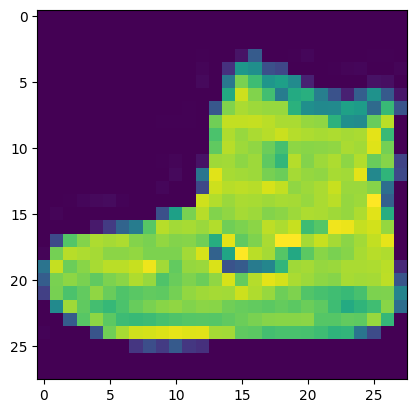

In [7]:
## 이미지 시각화 및 크기 확인

import PIL.Image as Image
import matplotlib.pyplot as plt
img = Image.fromarray(tr_images[0].numpy())
plt.imshow(img)
print(img.size)

In [8]:
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [9]:
# FashionMNIST 데이터셋을 Dataset 클래스로 만들기

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD, Adam

# 간단한 Linear 신경망 정의

def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [10]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [11]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [12]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [13]:
# 정의한 모델을 이용하여 학습, 평가
# epoch 당 loss, accuracy 저장 및 출력

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}" )
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4741, train_accuracy : 0.8598, val_loss : 0.4244, val_accuracy : 0.8437
epoch : 1
train_loss : 0.3567, train_accuracy : 0.8847, val_loss : 0.3702, val_accuracy : 0.8656
epoch : 2
train_loss : 0.3201, train_accuracy : 0.8895, val_loss : 0.3669, val_accuracy : 0.8653
epoch : 3
train_loss : 0.2947, train_accuracy : 0.9034, val_loss : 0.3334, val_accuracy : 0.8770
epoch : 4
train_loss : 0.2779, train_accuracy : 0.9044, val_loss : 0.3379, val_accuracy : 0.8786


- 학습 데이터셋의 Index 24300 (무작위 인덱스) 이미지를 학습 모델에 투입하여 예측값 확인
  - Trouser 클래스(1번 클래스)의 확률이 가장 큼

Text(0.5, 1.0, 'Trouser')

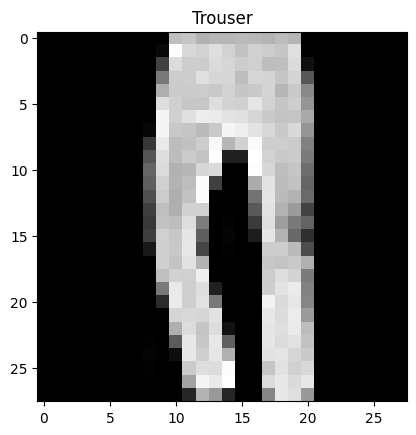

In [14]:
#ix = np.random.randint(len(tr_images))
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

- Translation
  - np.roll 함수를 사용하여 Index 24300 이미지를 좌우로 이동 (범위 -5~+5)

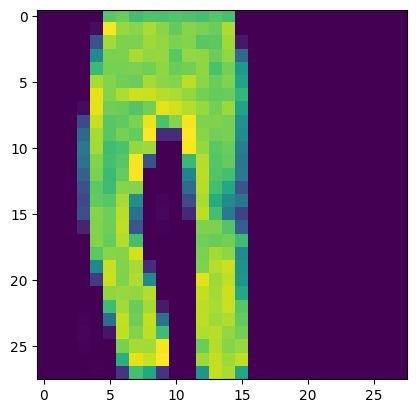

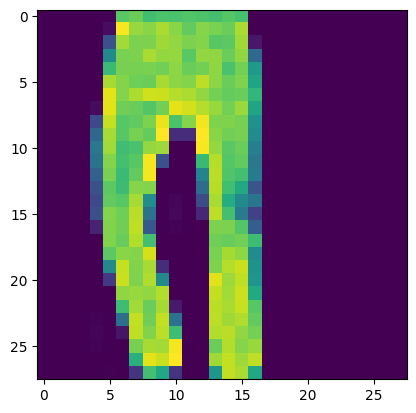

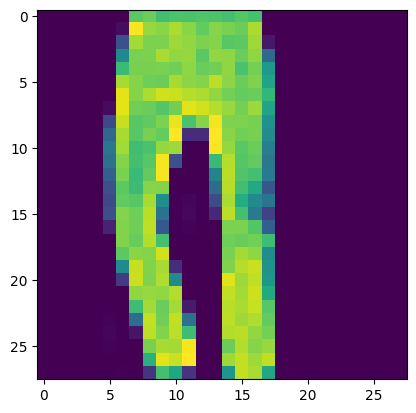

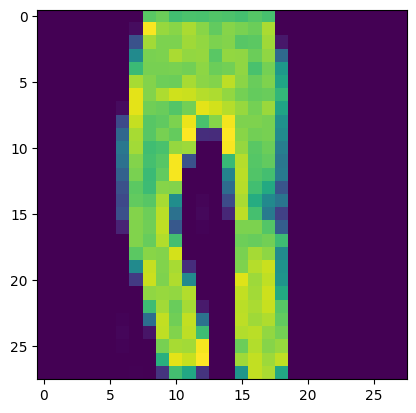

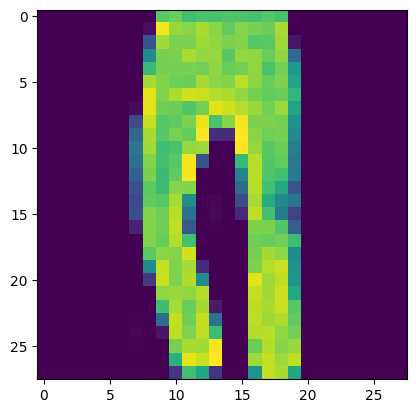

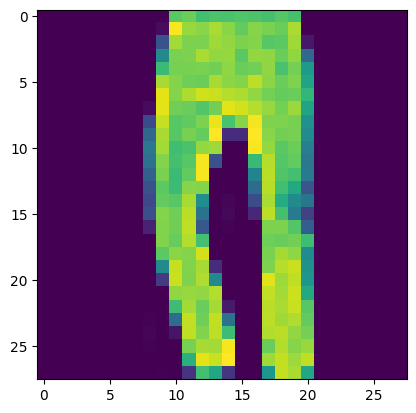

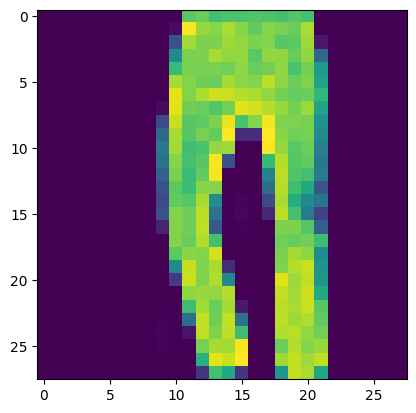

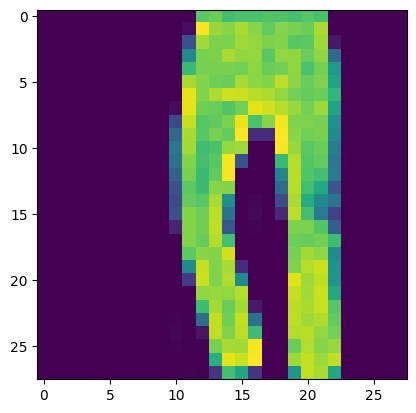

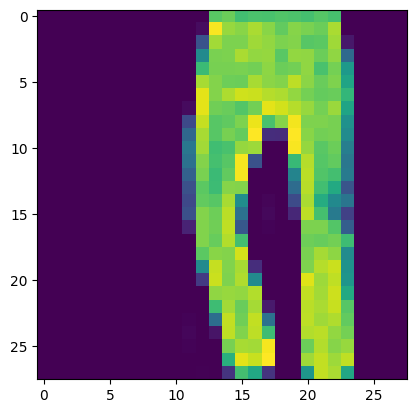

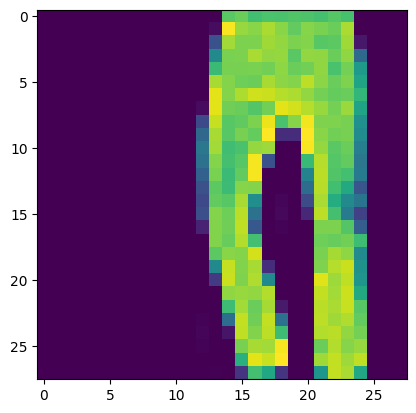

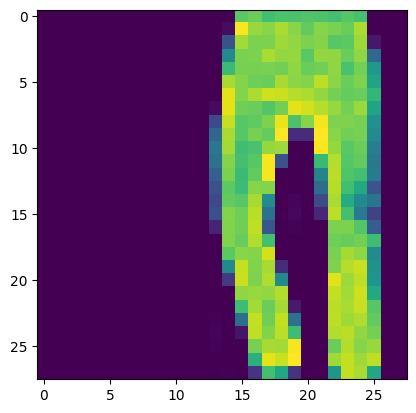

In [15]:
preds = []
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  #img2 = np.zeros((28,28))
  img2 = np.roll(img, px, axis=1)
  plt.imshow(img2)
  plt.show()
  img3 = torch.Tensor(img2).view(28*28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

#### 결과 확인

<Axes: title={'center': 'Probability of each class for various translations'}>

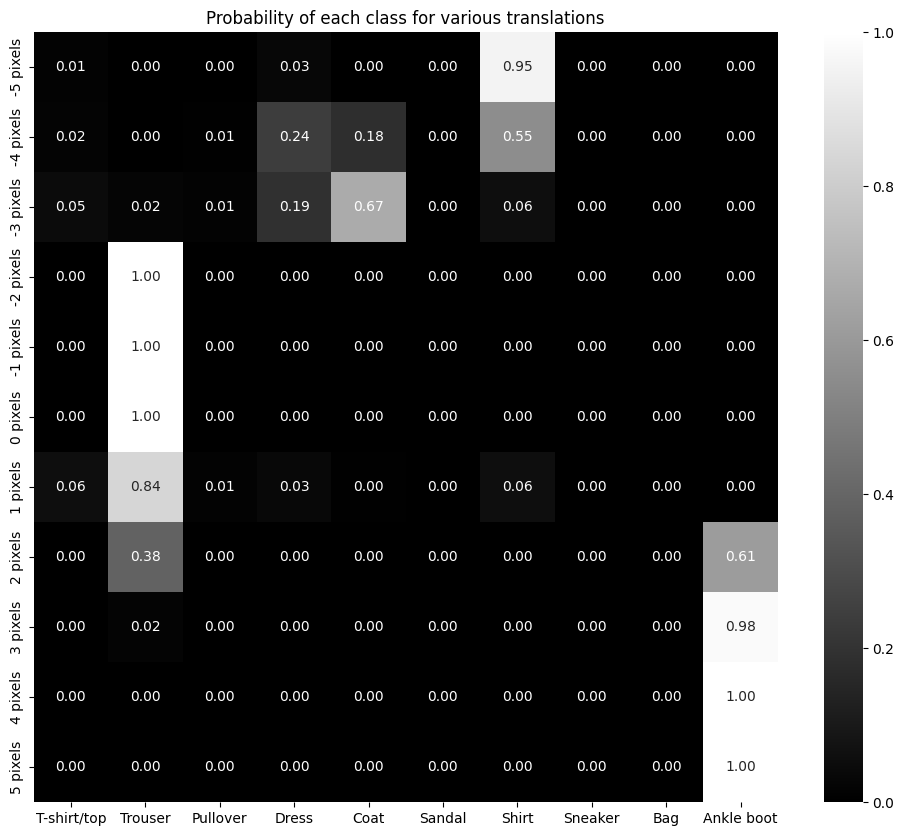

In [17]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

#### 인사이트를 적어주세요.

- 위 히트맵에서 세로축은 동일한 이미지를 좌우로 이동한 픽셀 수를 나타내며, 
- 가로축은 각 클래스에 대한 확률을 나타냅니다. 

- 픽셀 이동에 따른 변화
히트맵에서 각 행은 동일한 이미지가 좌우로 이동된 후의 모델 예측을 나타낸다. 모델이 작은 이동에 대해 비슷한 예측 확률을 유지한다면, 이는 모델이 이러한 작은 변형에 대해 강건하다는 것을 의미한다. 반면, 픽셀 이동에 따라 확률 분포가 급격히 변화한다면, 모델은 작은 변형에 민감할 수 있다.
좌우로 1~2픽셀 정도 이동했을 때 예측 확률이 크게 변하지 않는다면, 모델이 위치 변화에 대해 안정적인 성능을 보이고 있다는 것을 의미한다.

- 클래스 간 확률 분포
히트맵의 가로축에서 특정 클래스에 대한 확률이 매우 높거나 매우 낮다면, 이는 모델이 해당 클래스에 대해 명확한 구분을 하고 있음을 의미한다.
이동에 따라 클래스 확률의 변동이 있다면, 모델이 해당 이미지의 클래스에 대해 불확실하다는 것을 나타낼 수 있다. 이동이 큰 경우 이미지의 패턴이 다른 클래스와 유사하게 보일 수 있기 때문이다.

- 모델의 강건성
히트맵을 통해 모델의 강건성을 평가할 수 있다. 모델이 소규모 변형(픽셀 이동)에 민감하지 않다면, 다양한 환경에서도 안정적인 성능을 기대할 수 있다. 하지만 변형에 민감하다면, 실제 데이터에서 작은 왜곡이나 차이로 인해 성능이 저하될 가능성이 있다.

- 데이터 증강 필요성
히트맵에서 픽셀 이동에 따라 모델의 예측이 크게 변화한다면, 데이터 증강을 통해 모델을 개선할 수 있다. 예를 들어, 학습 데이터에 좌우 이동, 회전, 확대 등의 변형을 적용하면 모델이 다양한 상황에 더 강건해질 수 있다.

### 2. 합성곱 신경망 활용, FashionMNIST 이미지 분류

In [18]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28) 
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

- 아래 모델 summary를 보고 컨폴루션 레이어 안의 파라미터를 작성해주세요.
- stride = 1 (default), padding = 0으로 통일입니다.

In [20]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),  # 640 파라미터
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),  # 73,856 파라미터
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),  # 819,456 파라미터
        nn.ReLU(),
        nn.Linear(256, 10)  # 2,570 파라미터
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [21]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [22]:
trn_dl, val_dl = get_data()

In [26]:
#pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model,(1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [27]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch : {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"train_loss : {train_epoch_loss:.4f}, train_accuracy : {train_epoch_accuracy:.4f}, val_loss : {validation_loss:.4f}, val_accuracy : {val_epoch_accuracy:.4f}")

epoch : 0
train_loss : 0.4231, train_accuracy : 0.8972, val_loss : 0.3176, val_accuracy : 0.8826
epoch : 1
train_loss : 0.2728, train_accuracy : 0.9185, val_loss : 0.2708, val_accuracy : 0.8980
epoch : 2
train_loss : 0.2271, train_accuracy : 0.9352, val_loss : 0.2519, val_accuracy : 0.9096
epoch : 3
train_loss : 0.1924, train_accuracy : 0.9379, val_loss : 0.2595, val_accuracy : 0.9062
epoch : 4
train_loss : 0.1628, train_accuracy : 0.9494, val_loss : 0.2581, val_accuracy : 0.9106


### Plotting
- Fully-connected 레이어 기반 모델 대비 성능이 향상된 것을 확인할 수 있음

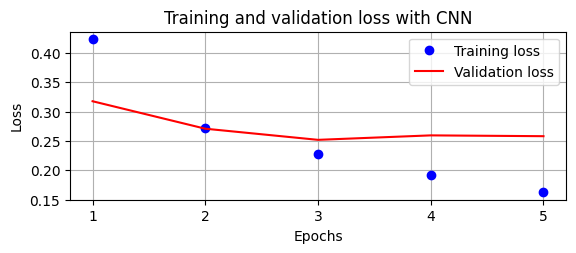

/tmp/ipykernel_23539/2406712320.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


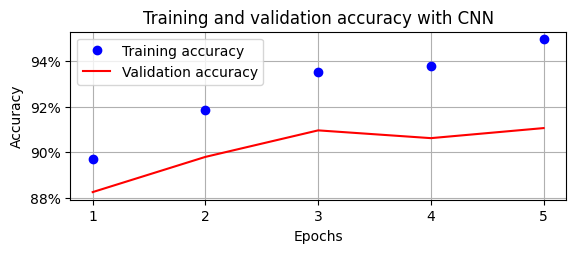

In [28]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

- 이미지를 이동시켰을 때, 성능이 어떻게 변화하는지 확인

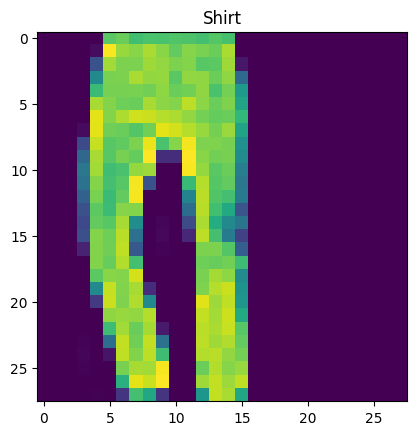

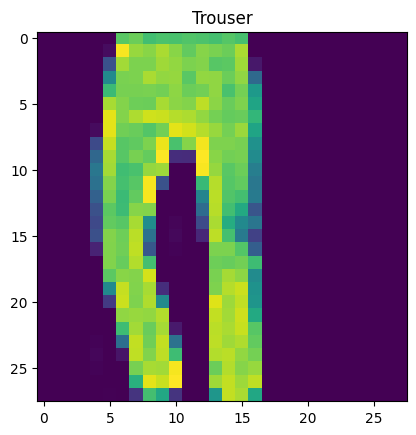

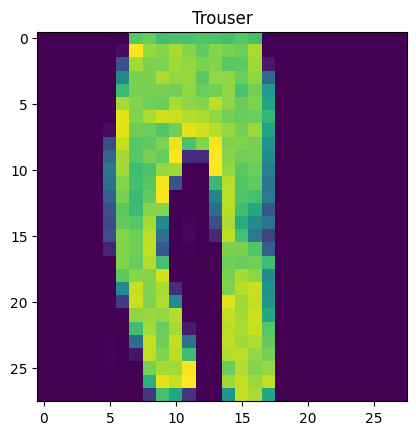

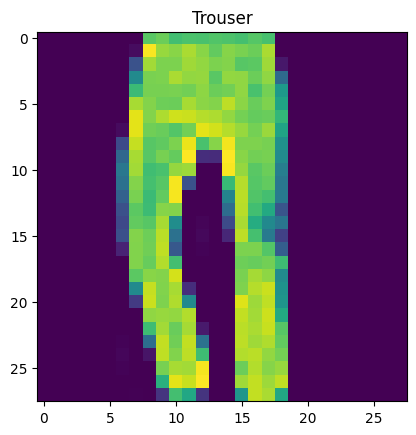

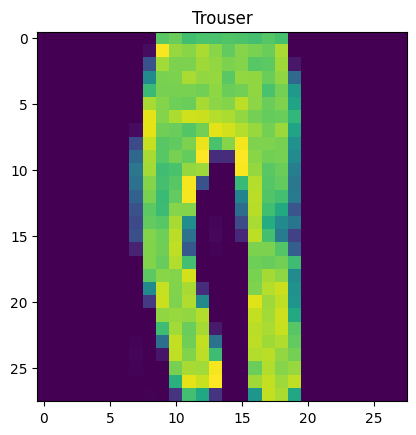

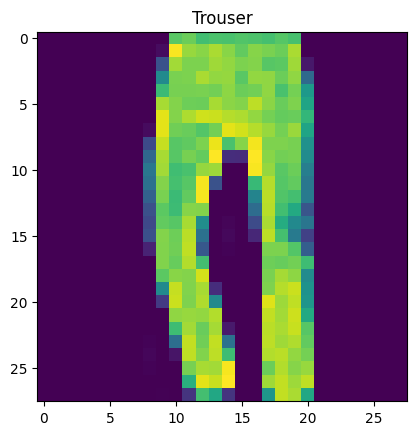

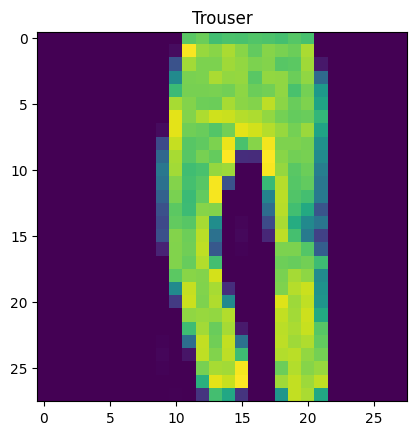

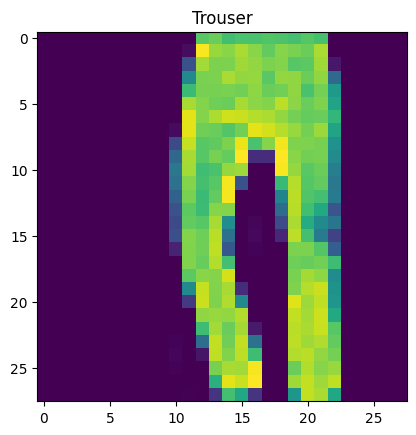

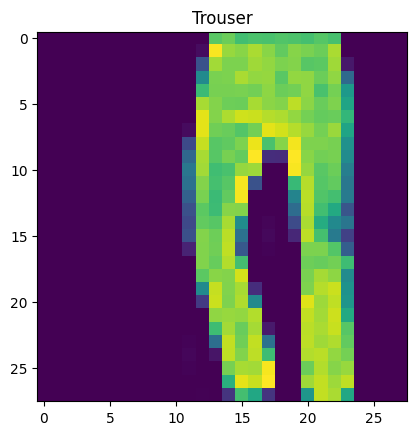

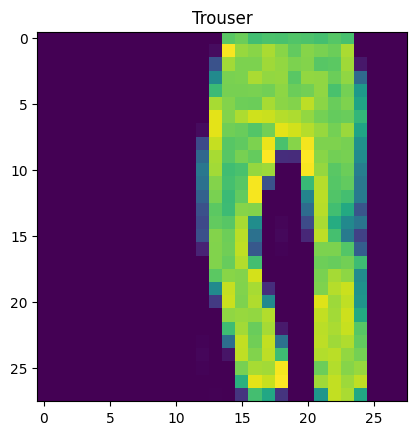

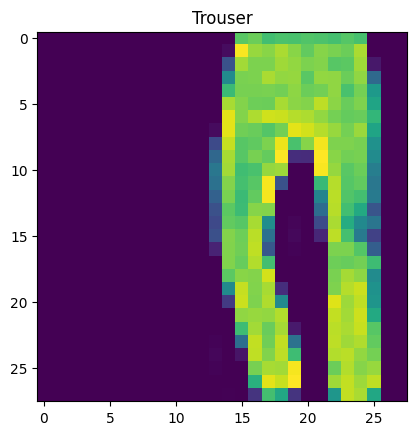

In [29]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [30]:
np.array(preds).shape # -5~+5로 이동시켜 가며(총 11 case), 10개 class로 분류될 확률 예측

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

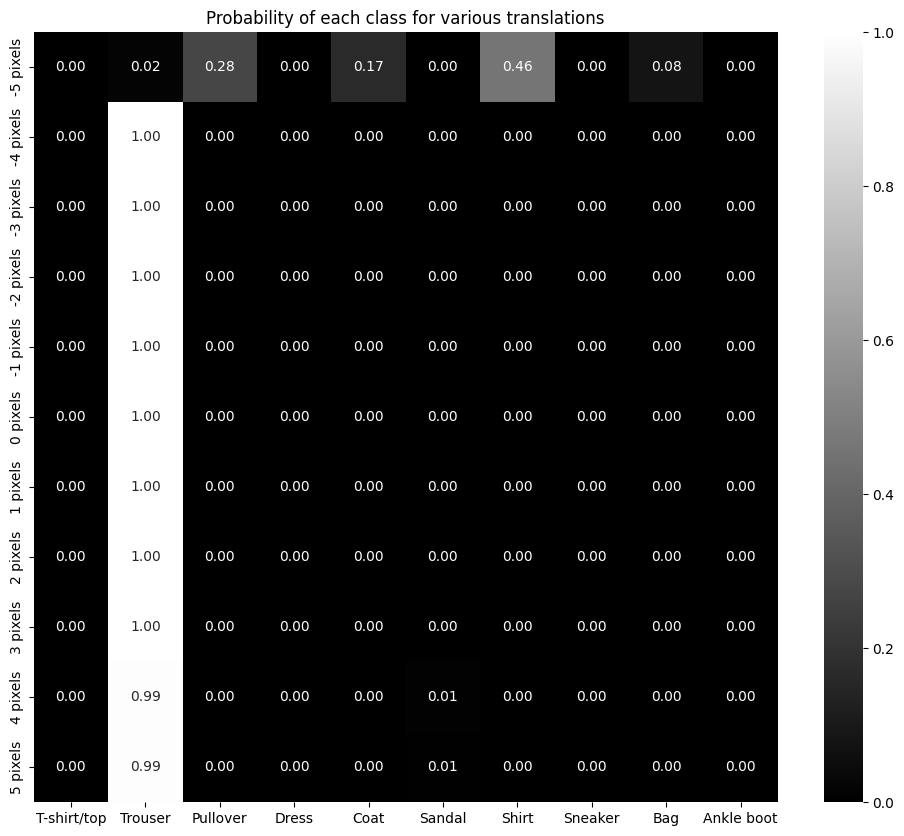

In [31]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

- 위 FC 신경망의 인사이트와 비교해서, 인사이트를 작성해주세요.

1. 모델 구조
FC 신경망: 이미지 데이터를 1차원 벡터로 변환한 후 완전 연결 계층으로 처리한다. 이 방식은 이미지의 공간적 구조를 무시하고, 모든 픽셀을 동일하게 취급한다.
CNN: CNN은 공간적 구조를 보존한 채로 필터를 사용해 이미지의 국소적인 패턴을 학습한다. Conv2d 계층은 이미지에서 특징 맵을 생성하고, MaxPooling은 특징을 축소하면서 중요한 정보만 유지한다. 이 방식은 이미지의 위치 불변성을 어느 정도 확보할 수 있다.
2. 파라미터 수와 계산 복잡도
FC 신경망: 파라미터 수가 매우 많다. 모든 입력 노드와 출력 노드가 연결되기 때문에, 입력 크기가 커질수록 파라미터 수가 기하급수적으로 증가한다. 이는 학습에 필요한 메모리와 계산 자원이 매우 많이 필요하게 만든다.
CNN: 파라미터 수가 상대적으로 적다. 각 필터는 입력의 일부를 처리하기 때문에 전체 파라미터 수가 감소한다. 특히, Conv2d 계층은 입력 전체가 아닌 지역적 패턴을 학습하므로 효율적이다. CNN은 이미지 같은 고차원 입력을 처리할 때 더 적합한 구조이다.
3. 모델의 강건성
FC 신경망: FC 신경망은 이미지의 작은 변형에 매우 민감할 수 있다. 이는 이미지의 구조적 특성을 학습하지 못하고, 단순히 개별 픽셀값 간의 관계를 학습하기 때문이다.
CNN: CNN은 이미지의 공간적 관계를 학습하므로, 작은 변형에 더 강건하다. 예를 들어, 좌우로 몇 픽셀 이동해도 CNN은 필터가 학습한 패턴을 인식할 수 있다. 이는 위치 불변성을 어느 정도 확보할 수 있음을 의미한다.
4. 특징 추출의 효율성
FC 신경망: 모든 픽셀이 동일한 중요성을 가진다고 가정하므로, 이미지의 지역적 특징을 잘 활용하지 못한다. 따라서 모델이 유의미한 특징을 학습하기 위해 더 많은 데이터를 필요로 할 수 있다.
CNN: CNN은 필터를 통해 국소적인 특징을 학습하므로, 이미지에서 중요한 패턴을 더 효율적으로 학습한다. 특징 맵은 점차 추상적인 정보를 담게 되며, 최종적으로 더 복잡한 특징을 학습할 수 있다.
5. 일반화 능력
FC 신경망: 학습 데이터에 의존적인 경향이 강하며, 데이터에 대한 일반화가 어려울 수 있다. 특히 새로운 데이터나 변형된 데이터에 대해 취약할 수 있다.
CNN: 필터와 풀링 계층을 통해 데이터에 대한 일반화 능력이 더 뛰어나다. 이미지의 위치나 형태가 약간 변해도 CNN은 이를 인식할 수 있으며, 이는 CNN의 특징 추출 능력 덕분이다.
6. 데이터 증강의 필요성
FC 신경망: 이미지의 작은 변형에도 매우 민감하므로, 데이터 증강이 필수적이다. 특히 이미지 이동, 회전, 스케일링 등 다양한 변형을 통해 모델을 보완해야 한다.
CNN: CNN은 필터를 통해 어느 정도 변형에 대해 강건하므로, 데이터 증강이 필요하지만 FC 신경망에 비해서는 덜 필요할 수 있다. 그래도 일반화 성능을 더욱 높이기 위해 데이터 증강은 여전히 중요한 역할을 한다.

# 3 ResNet BasicBlock 구현

- ResNet Basic Block 구현 과제 입니다.
- conv Sequential layer에는 Conv2d, ReLU를 포함해주세요.
- 순전파 함수에는 Skip Connection을 구현해주세요.

In [32]:
class ResLayer(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResLayer, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channels),  # ResNet에서 사용되는 BatchNorm
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channels, output_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False),
            nn.BatchNorm2d(output_channels)
        )
        
        # Identity mapping: input과 output의 크기가 다를 경우를 대비한 projection layer
        self.skip_connection = nn.Sequential()
        if stride != 1 or input_channels != output_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, x):
        identity = self.skip_connection(x)  # Skip connection (shortcut)
        out = self.conv(x)  # Convolution block
        out += identity  # Adding skip connection (element-wise addition)
        out = torch.relu(out)  # Final ReLU activation
        return out
